In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import ntpath
import keras
import sys
import imgaug
from imgaug import augmenters as iaa
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from keras.models import load_model
%matplotlib inline 

Using TensorFlow backend.


# **Importing Data**

In [3]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


# **Visualizing Data(CSV)**

In [4]:

datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [5]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


# **Plotting Steering Angles**

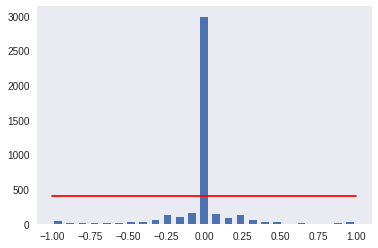

In [6]:
num_bins = 25
sample_limit = 400
hist,bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center,hist , width = 0.05)
plt.grid(axis = 'both')
plt.plot((np.min(data['steering']),np.max(data['steering'])), (sample_limit,sample_limit),color = 'r')

# **Balancing Data ** 
There are more 0 degree which might Bias the network towards driving staright

total data:  4053
removed:  2590
remaining:  1463


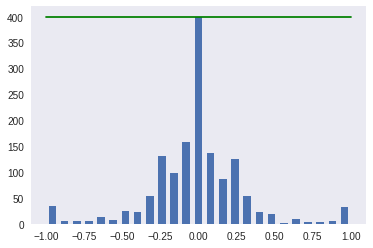

In [7]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if (data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]):
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[sample_limit:]
    remove_list.extend(list_)
print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining: ' , len(data))
            
hist,_ = np.histogram(data['steering'],num_bins)
plt.bar(center,hist , width = 0.05)
plt.grid(axis = 'both')
plt.plot((np.min(data['steering']),np.max(data['steering'])), (sample_limit,sample_limit), color = 'g')

# **Assigning Images and steering to respective variables**

There are three cameras Left, Right and Center through which images are captured

In [8]:
print(data.iloc[50])
def load_img_steering(data_dir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(data_dir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths,steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_50_818.jpg
left        left_2018_07_16_17_11_50_818.jpg  
right       right_2018_07_16_17_11_50_818.jpg 
steering   -0.2                               
throttle    1                                 
reverse     0                                 
speed       30.1805                           
Name: 96, dtype: object


# **Training and Validation Data Set Up**

In [9]:
X_train, x_valid,y_train, y_valid = train_test_split(image_paths,steerings, test_size = 0.2, random_state = 6)
print('Training Samples {} \nValidation Samples {}'.format(len(X_train), (len(x_valid))))

Training Samples 1170 
Validation Samples 293


# **Visualizing Training and VAlidation Data Split Ratio**

Text(0.5,1,'Validation data')

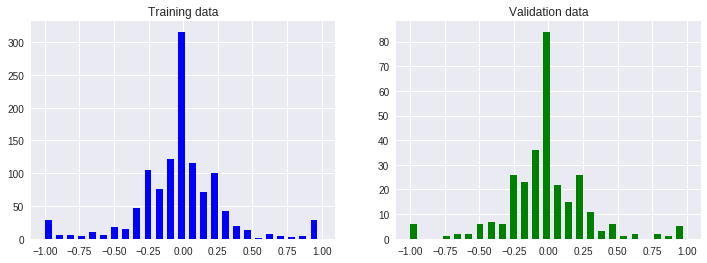

In [10]:
fig , axes = plt.subplots(1,2, figsize = (12,4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training data')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'green')
axes[1].set_title('Validation data')

# **Defining Data Augmentations:  **
Custom Augmentation Techniques using imgaug library

**1) Zoom Augmenter**

In [0]:
def zoom(image):
    zoom = iaa.Affine(scale= (1,1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5,1,'Zoomed Image')

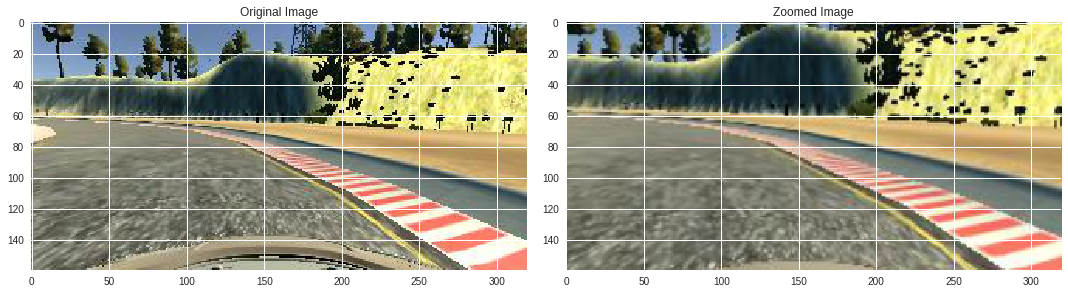

In [12]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

**2)Pan Augmenter**

In [0]:
def pan(image):
    pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5,1,'Paned Image')

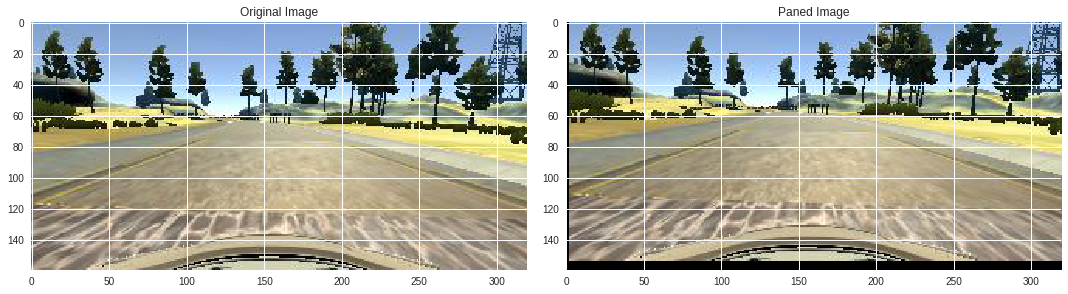

In [14]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(panned_image)
axes[1].set_title('Paned Image')

**3)Brightness Augmenter**

Text(0.5,1,'Brightness altered image ')

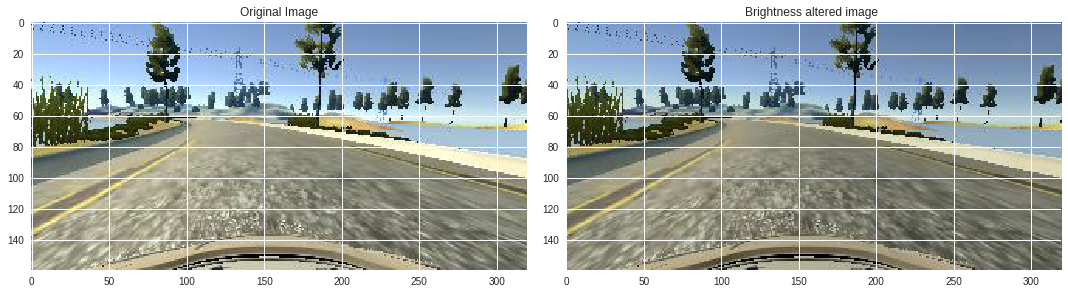

In [15]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

**4)Flip Augmenter**

In [0]:
def img_random_flip(image, steering_angle):
    image =cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5,1,'flippeded_image -0.0')

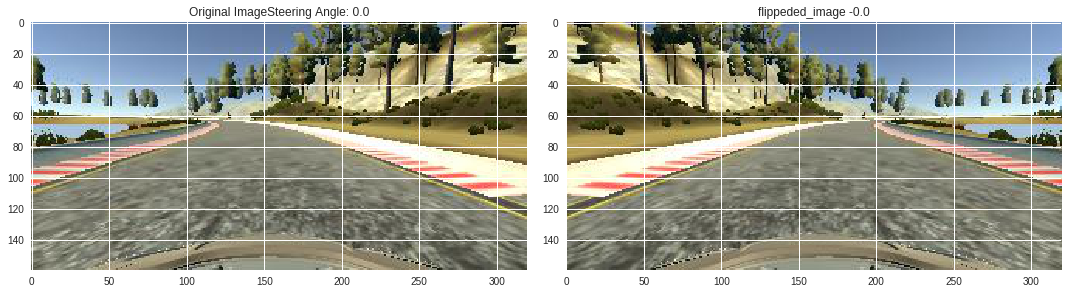

In [17]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
    
original_image = mpimg.imread(image)
flippeded_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)    
    
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image'+ 'Steering Angle: ' + str(steering_angle))
 
axs[1].imshow(flippeded_image)
axs[1].set_title('flippeded_image '+ str(flipped_steering_angle))

# **Augumenting Sampling Rate**
Augmenting only 50% of the time

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(original_image, steering_angle) 
    return image, steering_angle

# **Image Processing For Better Training the Model **
YUV visual plane has better efficiency then RGB in terms of recognition by the CNN architecture

In [0]:
def image_preprocessing(img):
    
    img = img[60:135,:,:]  
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img,(200,66))
    img = img/255
    return img
    

Text(0.5,1,'Processed Image')

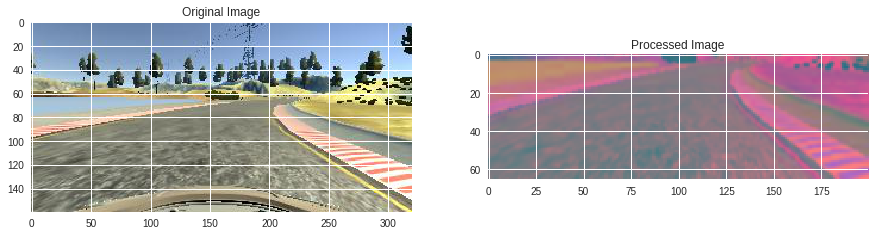

In [20]:
random_index = random.randint(0,1000)
image = mpimg.imread(image_paths[random_index])
original_image = image
processed_image = image_preprocessing(image)

_, space = plt.subplots(1,2, figsize = (15,10))
space[0].imshow(original_image)
space[0].set_title('Original Image')
space[1].imshow(processed_image)
space[1].set_title('Processed Image')


# **Batch generator** 
For generating images on the fly

In [0]:
def batch_generator(image_paths, steering_ang,batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range (batch_size):
            random_index = random.randint(0,len(image_paths)-1)
            
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
                
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            
            im = image_preprocessing(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))
        

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

Use these below cells if you are not using augmenters and only want to use image processing 

In [0]:
##X_train = np.array(list(map(image_preprocessing, X_train)));
##x_valid = np.array(list(map(image_preprocessing, x_valid)));

In [0]:
##plt.imshow(X_train[random.randint(0, len(X_train))])
##print(X_train.shape)

-------------------------------------------------------

# Nvidia Model
Model used by NVIDIA to train their self driving car:

1) Using 3 cameras

2) Imitation Learning

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), subsample = (2,2), input_shape = (66,200,3), activation = 'elu'))
    model.add(Conv2D(36, (5, 5), subsample = (2,2), activation = 'elu'))
    model.add(Conv2D(48, (5, 5), subsample = (2,2), activation = 'elu'))
    model.add(Conv2D(64, (3, 3), activation = 'elu'))
    model.add(Conv2D(64, (3, 3), activation = 'elu'))
   # model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
   # model.add(Dropout(0.5))
    
    model.add(Dense(50, activation = 'elu'))
  #  model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'elu'))
  #  model.add(Dropout(0.5))
    model.add(Dense(1))
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    model.compile(loss = 'mse', optimizer = adam)
    return model
              

In [24]:
model = nvidia_model() 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

**Model Training**

In [0]:

h = model.fit_generator(batch_generator(X_train, y_train,100, 1), 
                        steps_per_epoch = 300, epochs = 20,
                        validation_data = batch_generator(x_valid,y_valid, 100 , 0), 
                        validation_steps = 200, verbose = 0, shuffle = 1)

**Visualizing Model Efficiency**

Text(0.5,1,'loss')

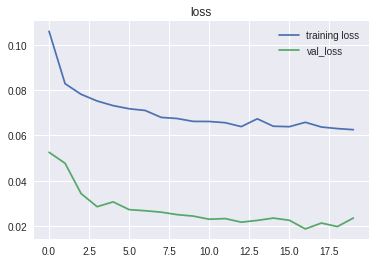

In [27]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training loss', 'val_loss'])
plt.title('loss')

**Saving Weights of the Trained Model **

Do this if you cant train your model at a single stretch

In [0]:
model.save_weights('my_model_weights.h5')

**Saving the model** 

After the training is complete we can use to drive our car Autonomously 

In [0]:
model.save('model.h5')

## **Congratulations You have built a Self - Driving Car**